In [161]:
import pandas as pd
import pyodbc
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori


In [162]:
sales_go = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=C:/Users/Jonat/Downloads/GO-databases schoon/go_sales_schoon.accdb;')

In [163]:
product = pd.read_sql("SELECT * FROM product", sales_go)
order_details = pd.read_sql("SELECT * FROM order_details", sales_go)
order_header = pd.read_sql("SELECT * FROM order_header", sales_go)
product_type = pd.read_sql("SELECT * FROM product_type", sales_go)



C:\Users\Jonat\AppData\Local\Temp\ipykernel_26776\3130275231.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  product = pd.read_sql("SELECT * FROM product", sales_go)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_26776\3130275231.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details = pd.read_sql("SELECT * FROM order_details", sales_go)
C:\Users\Jonat\AppData\Local\Temp\ipykernel_26776\3130275231.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_header = pd.read_sql("SELECT * FROM order_header", sales_g

# Data merging

In [164]:
product = pd.merge(product, product_type)
order_details = pd.merge(order_details, product)
order_details = order_details[["ORDER_NUMBER", "PRODUCT_TYPE_EN"]]
order_details

,ORDER_NUMBER,PRODUCT_TYPE_EN
0,1258,Sleeping Bags
1,1352,Sleeping Bags
2,1544,Sleeping Bags
3,1249,Sleeping Bags
4,1268,Sleeping Bags
...,...,...
43058,9174,Tents
43059,8529,Tents
43060,8628,Tents
43061,8672,Tents


# Frequency items

### Turning the product_type_en into true and false columns.
In the first section of the code, i make the columns of product_type more paletable for the apriori library, since it only takes in boolean values. In the second section, i use the apriori library to go through the tables of order_details, to see all of the combinations and the frequency of them appearring.

In [165]:
transactions = order_details.groupby('ORDER_NUMBER')['PRODUCT_TYPE_EN'].apply(list).tolist()

# use the TransactionEncoder to encode the transactions as a matrix of 1s and 0s
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

# convert the matrix into a pandas dataframe
order_details = pd.DataFrame(te_ary, columns=te.columns_)

# use the Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(order_details, min_support=0.20, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[ (frequent_itemsets['length'] > 1)]
frequent_itemsets

,support,itemsets,length
15,0.287873,"(Lanterns, Cooking Gear)",2
16,0.205597,"(Packs, Cooking Gear)",2
17,0.230784,"(Sleeping Bags, Cooking Gear)",2
18,0.224067,"(Lanterns, Packs)",2
19,0.239179,"(Lanterns, Sleeping Bags)",2
20,0.213060,"(Lanterns, Tents)",2


## The plot thinkens...
Here i grab the same variable as above, and place into a graph.

<AxesSubplot: >

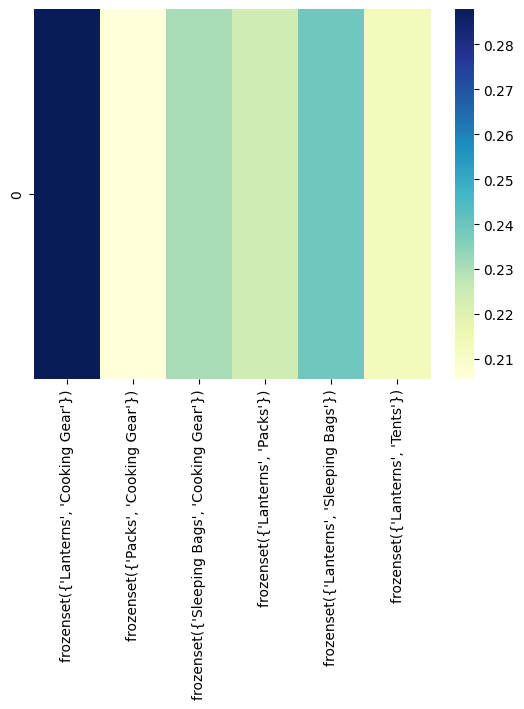

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a bar chart of the most frequent itemsets
sns.barplot(x='support', y='itemsets', data=frequent_itemsets.nlargest(20, 'support'))

# create a heatmap of the itemsets and their support values
itemsets = frequent_itemsets['itemsets'].tolist()
support = frequent_itemsets['support'].tolist()
itemset_dict = {}
for i, itemset in enumerate(itemsets):
    # print(itemset)
    # if len(itemset == 1):
    #     continue
    itemset_dict[str(itemset)] = support[i]
df_support = pd.DataFrame(columns=itemset_dict.keys())
df_support.loc[0] = itemset_dict.values()
sns.heatmap(df_support, cmap="YlGnBu")